In [148]:
import json
import webbrowser

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

from enroadspy.enroads_runner import EnroadsRunner
from evolution.outcomes.outcome_manager import OutcomeManager
from enroadspy.generate_url import actions_to_url
from moo.problems.enroads_problem import EnroadsProblem
from moo.problems.nn_problem import NNProblem

## Setup

In [183]:
context = False
# save_path = "results/pymoo/context-updated2"
save_path = "results/pymoo/ssd/ssds-fixed"
with open(save_path + "/config.json", 'r') as f:
    config = json.load(f)

actions = config["actions"]
outcomes = config["outcomes"]

with open(save_path + "/results", 'rb') as f:
    res = dill.load(f)
    print("Loaded Checkpoint:", res)

X = np.load(save_path + "/X.npy")
F = np.load(save_path + "/F.npy")

if not context:
    problem = EnroadsProblem(actions, outcomes)
else:
    context_df = pd.read_csv("experiments/scenarios/gdp_context.csv")
    context_df = context_df.drop(columns=["F", "scenario"])
    problem = NNProblem(context_df, {"in_size": len(context_df.columns), "hidden_size": 16, "out_size": len(actions)}, actions, outcomes)

runner = EnroadsRunner()
baseline_df = runner.evaluate_actions({})
outcome_manager = OutcomeManager(list(outcomes.keys()))
baseline_metrics = outcome_manager.process_outcomes({}, baseline_df)

print(outcomes)

Loaded Checkpoint: <pymoo.core.result.Result object at 0x16c7d8370>
make: `enroads' is up to date.
make: `enroads' is up to date.
{'Emissions Above Paris Agreement': True, 'Cost Change Squared': True, 'Energy Change Squared': True}


## Convergence Check

In [185]:
hypervolume_points = {
    "Emissions Above Paris Agreement": 0,
    "Cost Change Squared": 0,
    "Energy Change Squared": 0
}

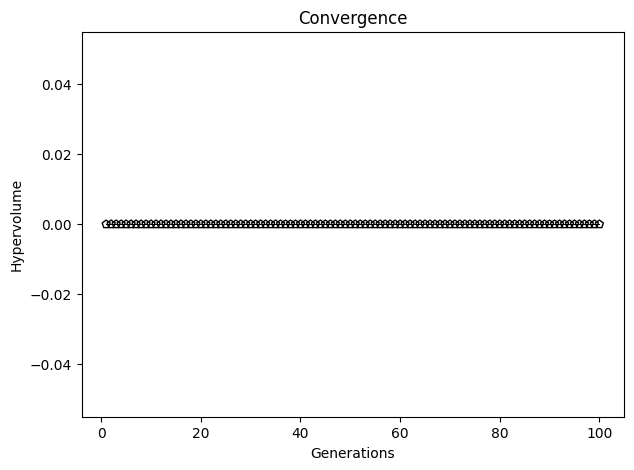

In [189]:
def extract_history(res):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

ideal = np.array([hypervolume_points[outcome] for outcome in outcomes])
metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(np.array(n_evals) / config["pop_size"], hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(np.array(n_evals) / config["pop_size"], hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
if save_path:
    plt.savefig(save_path + "/convergence.png", dpi=300)
plt.show()

## Objectives

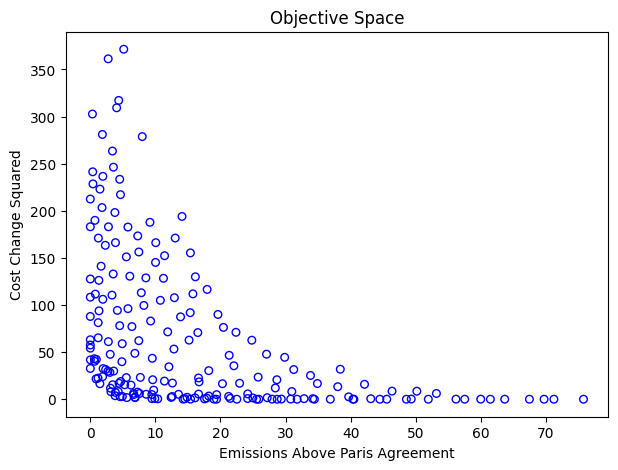

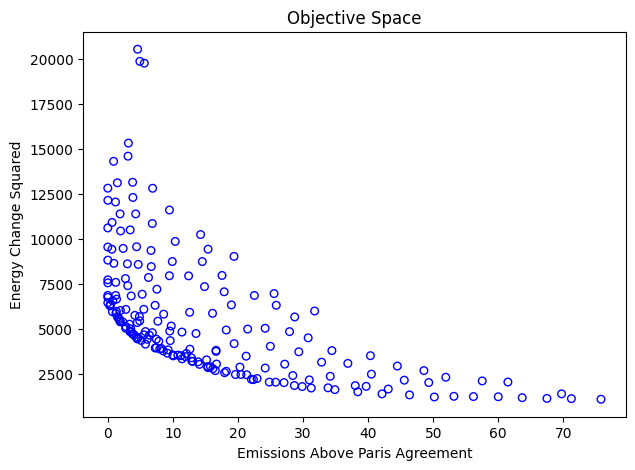

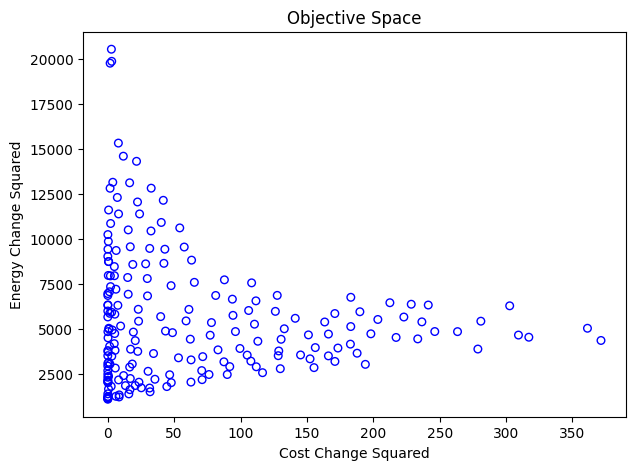

In [151]:
obj_idxs = (0, 1)
for i in range(F.shape[1]):
    for j in range(i+1, F.shape[1]):
        plt.figure(figsize=(7, 5))
        plt.scatter(F[:, i], F[:, j], s=30, facecolors='none', edgecolors='blue')
        plt.title("Objective Space")
        plt.xlabel(list(outcomes.keys())[i])
        plt.ylabel(list(outcomes.keys())[j])
        plt.show()

In [152]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

# sort_col_idx = -1
# sample_idxs = evenly_sample(np.argsort(F[:,sort_col_idx]), 9)
sample_idxs = list(range(10))
print(sample_idxs)
print(F[sample_idxs])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0.00000000e+00 2.12483411e+02 6.46491384e+03]
 [2.58846150e+01 0.00000000e+00 6.32476783e+03]
 [7.57789050e+01 9.00000000e-08 1.10994585e+03]
 [5.13666500e+00 3.71516220e+02 4.37035005e+03]
 [4.57920500e+00 2.69523494e+00 2.05315387e+04]
 [7.98177500e+00 2.78766436e+02 3.89437722e+03]
 [2.74649800e+00 3.61327954e+02 5.04778092e+03]
 [3.25105000e-01 3.02733376e+02 6.29307975e+03]
 [1.40884050e+01 1.94007840e+02 3.04471824e+03]
 [1.85350500e+00 2.81014510e+02 5.43977387e+03]]


In [166]:
ranges = np.array([[F[:, i].min(), F[:, i].max()] for i in range(F.shape[1])])
print(dict(zip(outcomes.keys(), ranges)))

{'Emissions Above Paris Agreement': array([ 0.      , 75.778905]), 'Cost Change Squared': array([  0.        , 371.51622005]), 'Energy Change Squared': array([ 1109.94585262, 20531.53870064])}


In [167]:
# Custom filters
# ranges[0] = np.array([0, 0])
# ranges[2] = np.array([1124, 10000])

In [168]:
lower_bounds = ranges[:, 0]
upper_bounds = ranges[:, 1]

mask = (F >= lower_bounds) & (F <= upper_bounds)
filtered_idxs = np.where(mask.all(axis=1))[0]
sample_idxs = filtered_idxs[:10]
sample_idxs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [169]:
def plot_parallel_coordinates(F, outcomes, cand_idxs, save_path=None):
    coords_dicts = []
    for cand_idx in range(F.shape[0]):
        results_dict = dict(zip(outcomes.keys(), F[cand_idx]))
        if cand_idx in cand_idxs:
            print(results_dict)
        # Since we always minimize we need to flip the sign of outcomes that are maximized.
        for key in results_dict:
            if not outcomes[key]:
                results_dict[key] = -results_dict[key]
        if cand_idx in cand_idxs:
            results_dict["cand_id"] = cand_idx
        else:
            results_dict["cand_id"] = "other"
        coords_dicts.append(results_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "other"], "cand_id", color=["lightgray"])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    condition = (normalized_df["cand_id"] != "other") & (normalized_df["cand_id"] != "Baseline")
    pd.plotting.parallel_coordinates(normalized_df[condition], "cand_id", color=colors)

    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "Baseline"], "cand_id", color="black")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

{'Emissions Above Paris Agreement': 0.0, 'Cost Change Squared': 212.48341119000006, 'Energy Change Squared': 6464.9138365088}
{'Emissions Above Paris Agreement': 25.884614999999997, 'Cost Change Squared': 0.0, 'Energy Change Squared': 6324.7678277558}
{'Emissions Above Paris Agreement': 75.778905, 'Cost Change Squared': 8.999999999958049e-08, 'Energy Change Squared': 1109.9458526189997}
{'Emissions Above Paris Agreement': 5.136664999999993, 'Cost Change Squared': 371.51622004999996, 'Energy Change Squared': 4370.350045439}
{'Emissions Above Paris Agreement': 4.579204999999995, 'Cost Change Squared': 2.6952349400000006, 'Energy Change Squared': 20531.53870064085}
{'Emissions Above Paris Agreement': 7.981774999999996, 'Cost Change Squared': 278.76643634999994, 'Energy Change Squared': 3894.377220568999}
{'Emissions Above Paris Agreement': 2.746497999999995, 'Cost Change Squared': 361.3279542799999, 'Energy Change Squared': 5047.780923309}
{'Emissions Above Paris Agreement': 0.32510499999

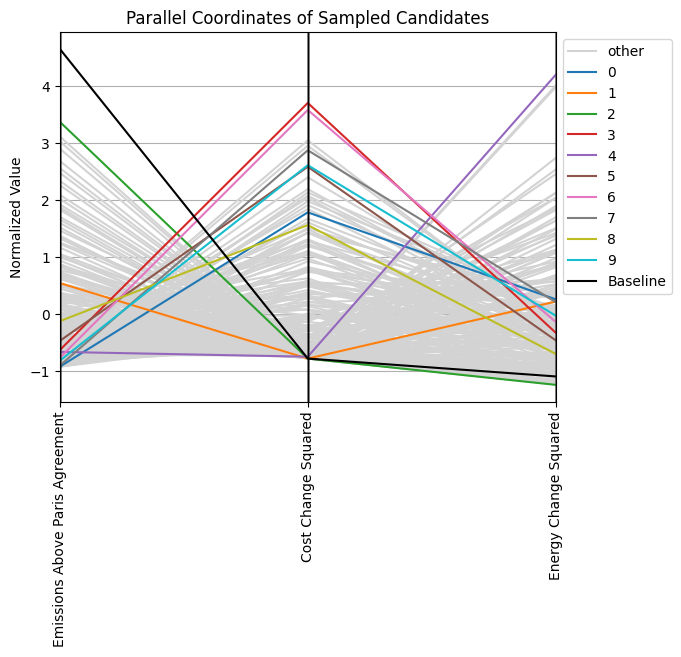

In [170]:
plot_parallel_coordinates(F, outcomes, sample_idxs, save_path=save_path + "/parallel.png")

## Outcomes

In [171]:
if not context:
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        actions_dict = problem.params_to_actions_dict(X[cand_idx])
        outcomes_df = runner.evaluate_actions(actions_dict)
        outcomes_dfs.append(outcomes_df)
else:
    all_outcomes_dfs = []
    all_context_actions_dicts = []
    for cand_idx in range(X.shape[0]):
        context_actions_dicts = problem.params_to_context_actions_dicts(X[cand_idx])
        all_context_actions_dicts.append(context_actions_dicts)
        cand_outcomes_dfs = problem.run_enroads(context_actions_dicts)
        all_outcomes_dfs.append(cand_outcomes_dfs)

In [172]:
def get_single_context_outcomes(all_outcomes_dfs: list[list[pd.DataFrame]], context_idx: int) -> list[pd.DataFrame]:
    outcomes_dfs = []
    for cand_outcomes_dfs in all_outcomes_dfs:
        outcomes_dfs.append(cand_outcomes_dfs[context_idx])
    return outcomes_dfs

def get_average_outcomes(all_outcomes_dfs: list[list[pd.DataFrame]]) -> list[pd.DataFrame]:
    outcomes_dfs = []
    for cand_outcomes_dfs in all_outcomes_dfs:
        concat_df = pd.concat(cand_outcomes_dfs, axis=0, keys=range(len(cand_outcomes_dfs)))
        average_df = concat_df.groupby(level=1).mean()
        outcomes_dfs.append(average_df)
    return outcomes_dfs

if context:
    outcomes_dfs = get_average_outcomes(all_outcomes_dfs)

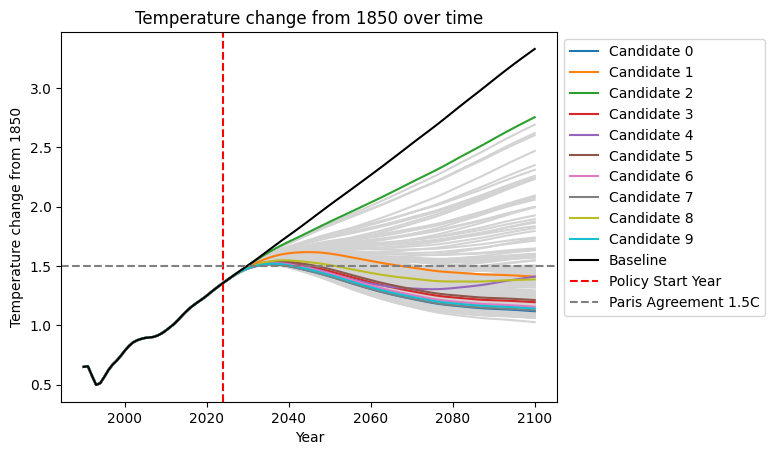

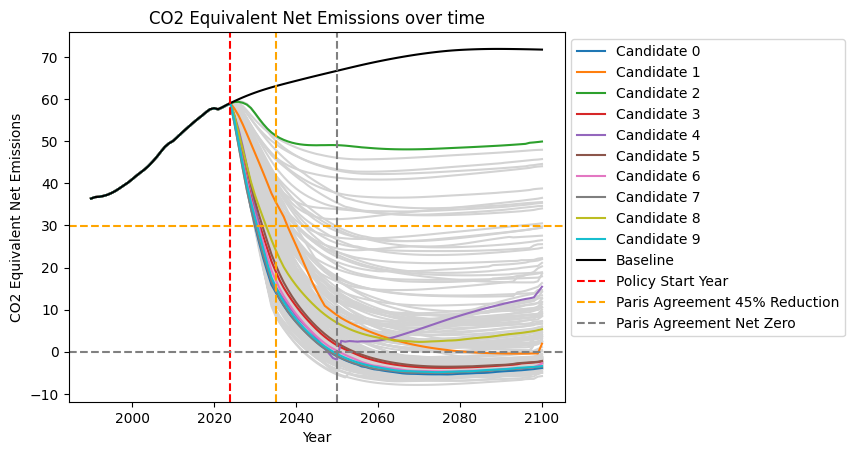

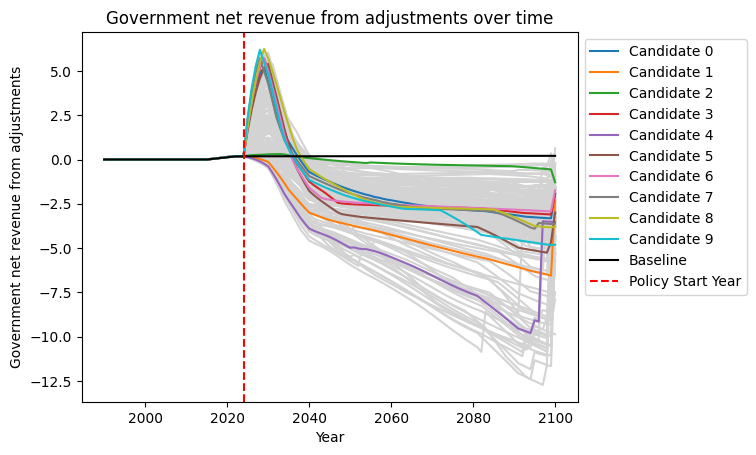

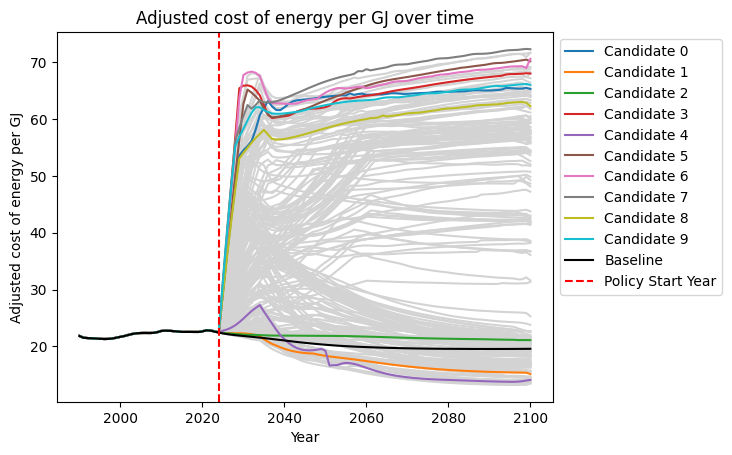

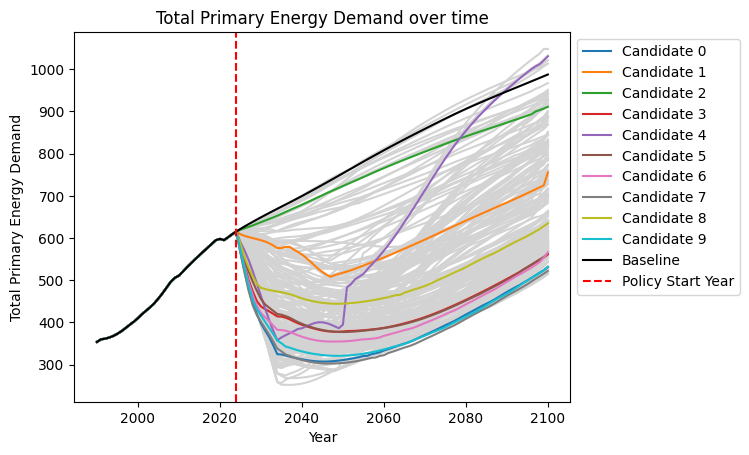

In [173]:
def plot_outcome_over_time(outcomes: list[str],
                           cand_idxs: list[int],
                           outcomes_dfs: list[pd.DataFrame],
                           baseline_df: pd.DataFrame,
                           save_path=None):
    for outcome in outcomes:
        for cand_idx in range(X.shape[0]):
            if cand_idx not in cand_idxs:
                plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], color="lightgray")
        for cand_idx in cand_idxs:
            plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], label=f"Candidate {cand_idx}")
        plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
        plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

        if outcome == "CO2 Equivalent Net Emissions":
            plt.axhline(y=0, color="gray", linestyle="--")
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

        elif outcome == "Temperature change from 1850":
            plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

        plt.legend(bbox_to_anchor=(1, 1))
        plt.title(f"{outcome} over time")
        plt.xlabel("Year")
        plt.ylabel(outcome)
        if save_path:
            plt.savefig(save_path + f"/{outcome.replace(' ', '-')}.png", bbox_inches='tight', dpi=300)
        plt.show()

plot_outcomes = ["Temperature change from 1850", "CO2 Equivalent Net Emissions", "Government net revenue from adjustments", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
plot_outcome_over_time(plot_outcomes, sample_idxs, outcomes_dfs, baseline_df, save_path=save_path)

In [174]:
def plot_energy_usage(cand_idxs: list[int], outcomes_dfs: list[pd.DataFrame], baseline_df: pd.DataFrame, save_path=None):
    fig, axes = plt.subplots(1, len(cand_idxs), sharey=True, figsize=(7.5 * len(cand_idxs), 5))
    if len(cand_idxs) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_idxs, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand_outcomes = outcomes_dfs[cand_id]
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    if save_path:
        plt.savefig(save_path + "/energy.png", dpi=300)
    plt.show()

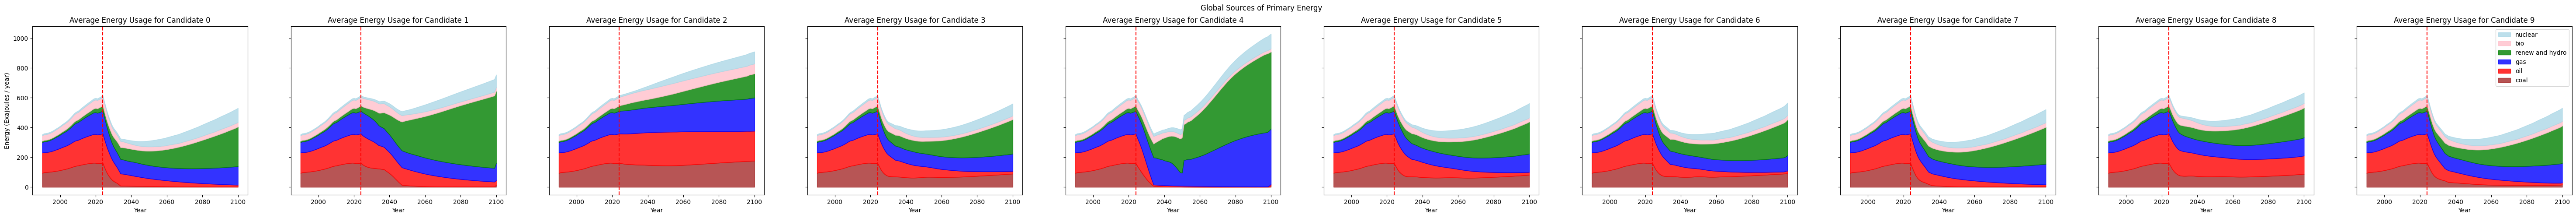

In [175]:
plot_energy_usage(sample_idxs, outcomes_dfs, baseline_df)

In [176]:
def open_idx(cand_idx: int, X: np.ndarray, problem: EnroadsProblem):
    actions_dict = problem.params_to_actions_dict(X[cand_idx])
    url = actions_to_url(actions_dict)
    webbrowser.open(url)

def open_context_idx(cand_idx: int, X: np.ndarray, problem: NNProblem, context_idx: int):
    context_actions_dicts = problem.params_to_context_actions_dicts(X[cand_idx])
    url = actions_to_url(context_actions_dicts[context_idx])
    webbrowser.open(url)

In [177]:
if not context:
    open_idx(sample_idxs[0], X, problem)
else:
    open_context_idx(sample_idxs[0], X, problem, 0)

## Compare Contexts

In [178]:
cand_idx = sample_idxs[5]
ssp_1_outcomes = get_single_context_outcomes(all_outcomes_dfs, 0)
ssp_3_outcomes = get_single_context_outcomes(all_outcomes_dfs, 2)

NameError: name 'all_outcomes_dfs' is not defined

In [ ]:
plot_outcome_over_time([plot_outcomes[0]], [cand_idx], ssp_1_outcomes, baseline_df)
plot_outcome_over_time([plot_outcomes[0]], [cand_idx], ssp_3_outcomes, baseline_df)

IndexError: list index out of range

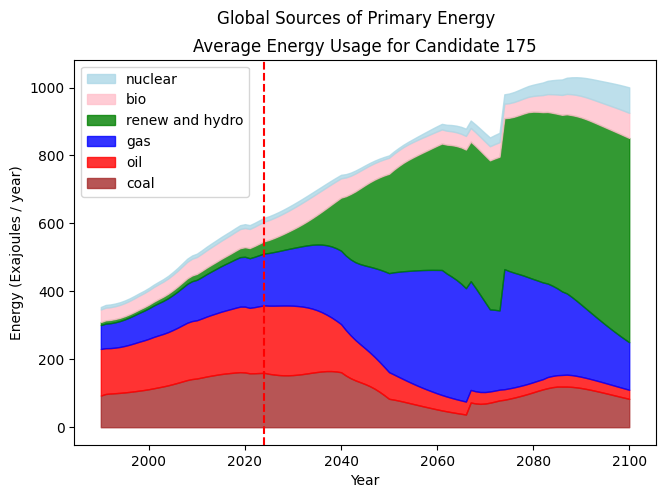

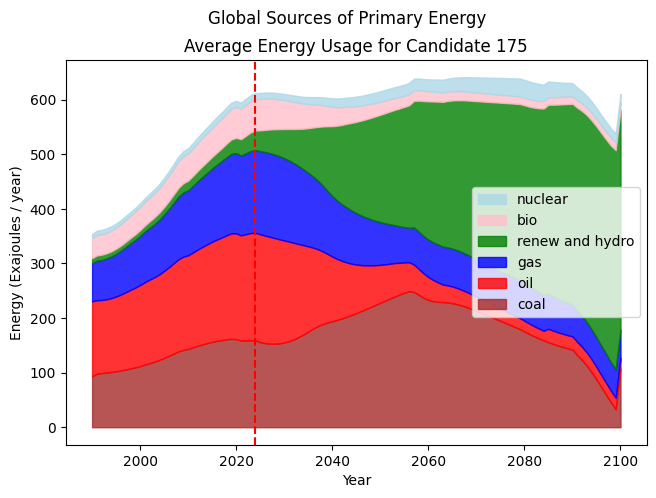

In [ ]:
plot_energy_usage([cand_idx], ssp_1_outcomes, baseline_df)
plot_energy_usage([cand_idx], ssp_3_outcomes, baseline_df)

In [ ]:
open_context_idx(cand_idx, X, problem, 0)
open_context_idx(cand_idx, X, problem, 1)
open_context_idx(cand_idx, X, problem, 2)
open_context_idx(cand_idx, X, problem, 3)
open_context_idx(cand_idx, X, problem, 4)

### Context Metrics

In [ ]:
# Get all metrics over candidate/contexts
all_metrics = []
for cand_context_actions_dicts, cand_outcomes_dfs in zip(all_context_actions_dicts, all_outcomes_dfs):
    metrics = []
    for context_actions_dicts, outcomes_df in zip(cand_context_actions_dicts, cand_outcomes_dfs):
        metrics.append(outcome_manager.process_outcomes(context_actions_dicts, outcomes_df))
    all_metrics.append(metrics)

[[[ 13   1   0 122   4]
  [ 11 182  59 167  25]
  [117   1  88   5  77]
  [138 194   0   2 108]
  [  3   1  75  33 162]]

 [[ 84  92  98   2 108]
  [ 99 198 131 153  83]
  [ 28 162  57   2  58]
  [  3   1  88  18  83]
  [ 13  98 168   3   4]]

 [[  3  66 148  61  25]
  [ 97  89 171  47  96]
  [ 55 194  52  16 121]
  [ 13 162 186  83  49]
  [ 84  27   0  13  96]]

 ...

 [[ 91  14 129  27  86]
  [ 68  87  85 139  15]
  [ 73  69  92  73  92]
  [  6  20  53  57  92]
  [139  54  90  40 119]]

 [[ 19   5 141  81   9]
  [ 66 195  16  19   8]
  [  7  42  94   7 124]
  [ 19   5 117  73   9]
  [ 19  10 144  27 101]]

 [[  6  20 199 139   8]
  [194 105 199 100  47]
  [ 92 190 199 104  35]
  [ 91  36 199   7  15]
  [  6  45 199  89   8]]]


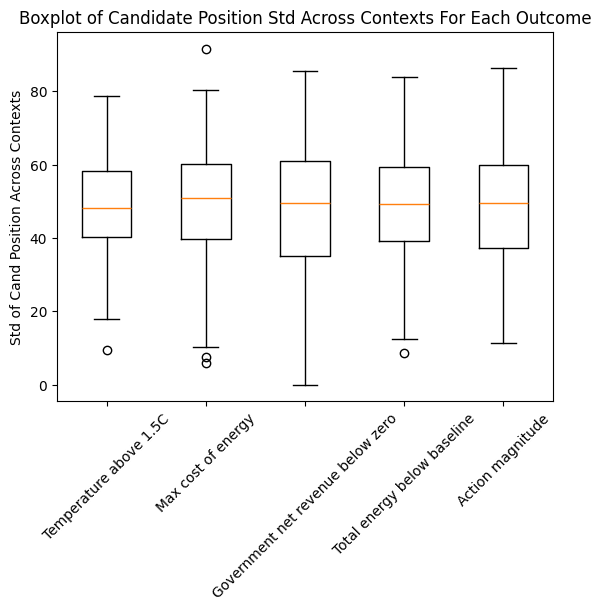

In [ ]:
def get_average_position_variance(all_metrics: list[list[dict[str, float]]], outcomes: dict[str, bool]):
    # Acquire array of candidate x context metric values
    metric_list = [[[context_metrics[metric] for metric in outcomes] for context_metrics in cand_metrics] for cand_metrics in all_metrics]
    metric_arr = np.array(metric_list)

    # Get ordering of candidates
    sorted_idxs = np.argsort(metric_arr, axis=0)
    print(sorted_idxs)
    # Get variance of each candidate's position over all the contexts
    idx_vars = np.std(sorted_idxs, axis=1)

    fig, ax = plt.subplots()
    ax.boxplot(idx_vars)
    ax.set_xticklabels(outcomes.keys())
    plt.xticks(rotation=45)
    plt.ylabel("Std of Cand Position Across Contexts")
    plt.title("Boxplot of Candidate Position Std Across Contexts For Each Outcome")
    plt.show()

get_average_position_variance(all_metrics, outcomes)